<a href="https://colab.research.google.com/github/Andrew-Kovalski/My-projects/blob/master/classification_of_Simpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Путешествие по Спрингфилду
В данном задании необходимо было классифицировать персонажей Симпсонов. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Импортируем необходимые библиотеки

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import pickle
import random
import shutil 
import torch
import torchvision
import os
import copy
import datetime

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
def init_random_seed(value=0): # зададим все сиды одной функцией
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed(42)

Возьмем объект SimpsonsDataset из [ноутбука](https://colab.research.google.com/drive/1slzf6-xJfqoMoRpVdNJuG0TSeUATPnRP#scrollTo=Xw7YkEefehWo) авторов курса.

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.Resize((224, 224)),                            
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

В данной части находится код для трансформации изображений. Всего в тренировочном датасете 20933 картинки. Но распределение классов неравномерное. Чтобы повысить качество модели, сделаем аугментацию небольших классов. Условно разобьем выборку на 3 категории. Малый класс - меньше 10 изображений, средний класс - от 10 до 100 изображений, большой - свыше 100. Большой класс изображений просто переведем в класс тензоров с нормализацией. В среднем каждую картинку с помощью transforms.TenCrop() разобъем на 10 тензоров, а для малого класса - на 100.

In [0]:
# трансформация для малого класса. Имеет 2 уровня трансформации. Возвращает тензор размерности [100, 3, 224, 224]
min_train_transforms = transforms.Compose([  
                                           transforms.Resize((230, 230)),
                                           transforms.TenCrop(224, vertical_flip=True),
                                           transforms.Lambda(
                                               lambda crops: torch.cat([aug_lvl_1a(crop) for crop in crops]))
])
# первый уровень трансформации                                           
aug_lvl_1a = transforms.Compose([ 
                                 transforms.RandomHorizontalFlip(p=0.7),
                                 transforms.TenCrop(224),
                                 transforms.Lambda(
                                     lambda crops: torch.stack([aug_lvl_2a(crop) for crop in crops]))
])    

# второй уровень трансформации  
aug_lvl_2a = transforms.Compose([
                                 transforms.ColorJitter(
                                     brightness = 0.175,   
                                     contrast   = 0.175,   
                                     saturation = 0.195,   
                                     hue        = (0.1, 0.25)),
                                 transforms.RandomRotation(360),  
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                 transforms.Lambda(
                                     lambda x: x[np.random.permutation(3), :, :]) # перемешивание слоев                           
])

# трансформация для среднего класса. Имеет один уровень. Возвращает тензор размерности [10, 3, 224, 224]
middle_train_transforms = transforms.Compose([  
                                           transforms.Resize((230, 230)),
                                           transforms.TenCrop(224, vertical_flip=True),
                                           transforms.Lambda(
                                               lambda crops: torch.stack([aug_lvl_1b(crop) for crop in crops]))
])
# первый и единственный уровень трансформации 
aug_lvl_1b = transforms.Compose([
                                 transforms.ColorJitter(
                                     brightness = 0.18,   
                                     contrast   = 0.18,   
                                     saturation = 0.18,   
                                     hue        = (0.1, 0.25)),
                                 transforms.RandomRotation(360),  
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                 transforms.Lambda(
                                     lambda x: x[np.random.permutation(3), :, :])                            
])

# трансформация для всей выборки
train_transforms = transforms.Compose([
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Основная идея состоит в следующем. Всю выборку с предварительным изменением 
# размера изображения переводим в тензоры. Затем с помощью аугментации 
# увеличиваем количество изображений в малом и среднем классах, а далее 
# при обучении модели к основной выборке будем добавлять дополнительную
# выборку, полученную аугментацией

In [0]:
TRAIN_DIR = '/content/gdrive/My Drive/simpsons/train/simpsons_dataset'
tr_dr = Path(TRAIN_DIR)
train_val_files = sorted(list(tr_dr.rglob('*.jpg')))
DATA_MODES = ['train', 'val', 'test']

In [0]:
from sklearn.model_selection import train_test_split

# разбиение выборки на тренировочную и валидационную
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

In [0]:
# создадим вот такой датасет. В дальнейшем он не используется.
# Это сделано ради методов, которые имеет объект ImageFolder
fake_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR)

In [0]:
from collections import Counter

classes = fake_dataset.classes                               # Классы
count_of_every_class = dict(Counter(fake_dataset.targets))   # Количество изображений в каждом классе
classes_idx = fake_dataset.class_to_idx                      # Словарь, в котором keys - классы, values - лейблы.

In [0]:
# создание списков малого и среднего класса
min_classes = []    # Малый
middle_classes = [] # Средний
for key in count_of_every_class.keys():
    if count_of_every_class[key]<=10:
       min_classes.append(key)
    elif (count_of_every_class[key]>10) & (count_of_every_class[key]<=100):
       middle_classes.append(key)
print(min_classes, '/n', middle_classes)

[10, 19, 40] /n [1, 5, 8, 12, 13, 23, 26, 30, 31, 33, 34, 35, 38, 39]


In [0]:
# Теперь создадим локальную папку, в которую поместим малые классы
min_train_dir = 'min_train'

min_class_names = [classes[i] for i in min_classes]

for class_name in min_class_names:
    os.makedirs(os.path.join(min_train_dir, class_name), exist_ok=True)

for class_name in min_class_names:
    source_dir = os.path.join(TRAIN_DIR, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        dest_dir = os.path.join(min_train_dir, class_name) 
        shutil.copy(os.path.join(source_dir, file_name),
                    os.path.join(dest_dir, file_name)
                    )

100%|██████████| 8/8 [00:00<00:00, 474.47it/s]


In [0]:
# Аналогичные действия для среднего класса
middle_train_dir = 'middle_train'

middle_class_names = [classes[i] for i in middle_classes]

for class_name in middle_class_names:
    os.makedirs(os.path.join(middle_train_dir, class_name), exist_ok=True)

for class_name in middle_class_names:
    source_dir = os.path.join(TRAIN_DIR, class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        dest_dir = os.path.join(middle_train_dir, class_name) 
        shutil.copy(os.path.join(source_dir, file_name),
                    os.path.join(dest_dir, file_name)
                    )

100%|██████████| 55/55 [00:00<00:00, 645.47it/s]


In [0]:
!nvidia-smi
torch.cuda.is_available()

Fri Jan 10 12:02:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [0]:
# Данная функция нужна, чтобы преобразовать лейблы для тензоров, полученных аугментацией.
# ImageFolder будет присваивать новые лейблы для каждого класса. А функция вернет значения первоначальных лейблов.
def target_transform(trgt, cls_idx, cls_list):
    return cls_idx[cls_list[trgt]]

min_trgt_tr_func = lambda x: target_transform(x, classes_idx , min_class_names) 
middle_trgt_tr_func = lambda x: target_transform(x, classes_idx , middle_class_names)   

In [0]:
# аугментация малого тренировочного датасета
min_train_dataset = torchvision.datasets.ImageFolder('/content/min_train', min_train_transforms, min_trgt_tr_func)

# аугментация среднего тренировочного датасета
middle_train_dataset = torchvision.datasets.ImageFolder('/content/middle_train', middle_train_transforms, middle_trgt_tr_func)

In [0]:
#Эта функия нужна, чтобы "размножить" метки. 
def create_target_set(variable, size_target, dtype = torch.long): 

    target = torch.tensor([variable], dtype = dtype, requires_grad=False)
    target = torch.nn.functional.pad(target,
                                     (size_target//2, size_target//2 - 1),
                                     "constant",
                                     variable)
    
    return target

# А эта функция используется для того, чтобы из тензоров размерности 
# [10, 3, 224, 224] и [100, 3, 224, 224] получить список кортежей вида
# (tensor, label), где tensor.shape = [3, 224, 224]

def conversion(dataset, n):  
                                                                               
    data = []
    target = []

    for dt, trgt in tqdm(dataset):
        data.append(dt.data)
        if n>1:
           target.append(create_target_set(trgt, n))
        else: 
           target.append(torch.tensor([trgt], dtype = torch.long, requires_grad=False))

    #Объединение тензоров
    dtst = list(
        zip(torch.cat(data , dim = 0), torch.cat(target, dim = 0))
        )
    
    return dtst

In [0]:
len(train_dataset)//43


365

In [0]:
# преобразование датасетов
new_min_dataset = conversion(min_train_dataset, 100)
new_middle_dataset = conversion(middle_train_dataset, 10)

100%|██████████| 727/727 [00:59<00:00, 12.23it/s]


In [0]:
# объединение датасетов
sub_dataset = new_min_dataset + new_middle_dataset
del new_min_dataset, new_middle_dataset

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

# Визуализация выборки, полученной аугментацией

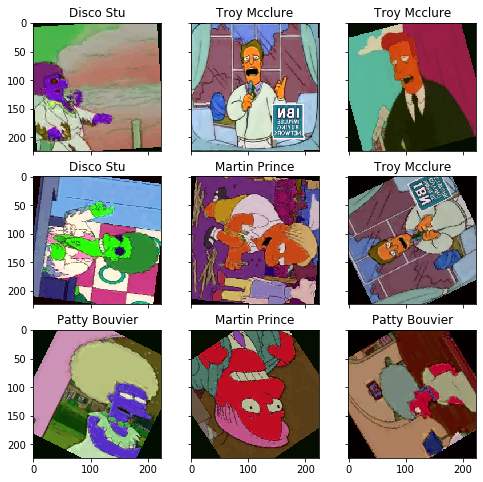

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,9000))
    im_val, label = sub_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), classes[label].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Загрузка модели
Обучать будем ResNext50_32x4d 

In [0]:
model = torchvision.models.resnext50_32x4d(pretrained=True)

In [0]:
for param in model.parameters():
    param.requires_grad = True  

model.fc = torch.nn.Linear(model.fc.in_features, len(classes))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

Функцию обучения позаимствуем [отсюда](https://github.com/Samsung-IT-Academy/stepik-dl-nlp/tree/master/dlnlputils).

In [0]:
# Функция, которая переносит вычисления на GPU
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

# Функция обучения
def train_eval_loop(model, train_dataset, val_dataset, 
                    subsidiary_dataset,
                    criterion,
                    lr=1e-4, epoch_n=10, batch_size=32, subsidiary_batch_size=0,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=torch.utils.data.DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0,
                    dataloader_workers_n_sub=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param subsidiary_dataset: list - допольнительные данные для обучения, получанные аугментацией
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param subsidiary_batch_size: количество  дополнительных примеров, которые добавляем к основным
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)
    subsidiary_dataloader = data_loader_ctor(subsidiary_dataset, batch_size=subsidiary_batch_size, shuffle=shuffle_train,
                                          num_workers=dataloader_workers_n_sub)
    
    sub_loader_list=[]
    del subsidiary_dataset
    for x, y in tqdm(subsidiary_dataloader):
        sub_loader_list.append((x,y))

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i+1))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                sub_batch_x, sub_batch_y = sub_loader_list[batch_i]

                batch_x = torch.cat((batch_x, sub_batch_x))
                batch_y = torch.cat((batch_y, sub_batch_y))


                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                            (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

# Функция классификации для полного набора данных
def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=32, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    results_by_batch = []

    device = torch.device(device)
    model = model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = batch_x.to(device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

# Обучение модели
Алгоритм обучения Adam, обучаем на 18 эпохах. learning rate = 0.0001. Размер батча для основной выборки 43, а дополнительной 25. Они подобраны такими специально. Целая часть деления 15698/43 равна 365, а 9170/25 - 366, где 15698 - размер тренировочного сета, 9170 - размерность дополнительного сета. Это значит, что при обучении можно будет получить большое количество батчей, одинаковых по размерности, с минимальными потерями дополнительных данных. То есть всего один полный батч из доп выборки не будет участвовать в обучении. Максимальное число итераций так же установим 365, чтобы в обучении участвовали только полные батчи.

In [0]:
(best_val_loss,
 best_model) = train_eval_loop(model,
                               train_dataset,
                               val_dataset,
                               sub_dataset, 
                               criterion=torch.nn.CrossEntropyLoss(),
                               lr=1e-4,
                               epoch_n=18,
                               batch_size=43,
                               subsidiary_batch_size=25,
                               device=device,
                               early_stopping_patience=5,
                               max_batches_per_epoch_train=365,
                               max_batches_per_epoch_val=10000, 
                               lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 
                                                                                                          patience=3,
                                                                                                          factor=0.1,
                                                                                                          verbose=True),
                               dataloader_workers_n=40,
                               dataloader_workers_n_sub=25)

100%|██████████| 367/367 [00:06<00:00, 59.72it/s]

Эпоха 1


Эпоха: 366 итераций, 204.05 сек
Среднее значение функции потерь на обучении 0.5464357355294006
Среднее значение функции потерь на валидации 0.11610993357436335
Новая лучшая модель!

Эпоха 2
Эпоха: 366 итераций, 204.28 сек
Среднее значение функции потерь на обучении 0.03975920050145417
Среднее значение функции потерь на валидации 0.10963884754617867
Новая лучшая модель!

Эпоха 3
Эпоха: 366 итераций, 204.65 сек
Среднее значение функции потерь на обучении 0.01509617543887459
Среднее значение функции потерь на валидации 0.10283674286477092
Новая лучшая модель!

Эпоха 4
Эпоха: 366 итераций, 204.12 сек
Среднее значение функции потерь на обучении 0.013811069261727987
Среднее значение функции потерь на валидации 0.11034915688615597

Эпоха 5
Эпоха: 366 итераций, 204.51 сек
Среднее значение функции потерь на обучении 0.03604060192745118
Среднее значение функции потерь на валидации 0.12502746909120135

Эпоха 6
Эпоха: 366 итераций, 204.86 сек
Среднее значение функции потерь на обучении 0.018851477

In [0]:
# Сохранение модели
path = f"/content/gdrive/My Drive/resnext50_simpsons_6" 
torch.save(best_model.state_dict(), path)

In [0]:
# Загрузка модели
path = f"/content/gdrive/My Drive/resnext50_simpsons" 
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Контроль качества

In [0]:
from sklearn.metrics import classification_report

train_pred, train_labels=  predict_with_model(best_model, train_dataset, return_labels=True)
train_loss = torch.nn.CrossEntropyLoss()(torch.tensor(train_pred),
                             torch.tensor(train_labels))
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(train_labels, train_pred.argmax(1).reshape(-1), target_names=classes))
print()

val_pred, val_labels = predict_with_model(best_model, val_dataset, return_labels=True)
val_loss = torch.nn.CrossEntropyLoss()(torch.tensor(val_pred),
                            torch.tensor(val_labels))
print('Среднее значение функции потерь на валидации', float(val_loss))
print(classification_report(val_labels, val_pred.argmax(1).reshape(-1), target_names=classes))

491it [01:04, 13.77it/s]                              
  0%|          | 0/163.53125 [00:00<?, ?it/s]

Среднее значение функции потерь на обучении 0.0002687851374503225
                          precision    recall  f1-score   support

  abraham_grampa_simpson       1.00      1.00      1.00       683
           agnes_skinner       1.00      1.00      1.00        32
  apu_nahasapeemapetilon       1.00      1.00      1.00       467
           barney_gumble       1.00      1.00      1.00        80
            bart_simpson       1.00      1.00      1.00      1006
            carl_carlson       1.00      1.00      1.00        74
charles_montgomery_burns       1.00      1.00      1.00       895
            chief_wiggum       1.00      1.00      1.00       739
         cletus_spuckler       1.00      1.00      1.00        35
          comic_book_guy       1.00      1.00      1.00       352
               disco_stu       1.00      1.00      1.00         6
          edna_krabappel       1.00      1.00      1.00       343
                fat_tony       1.00      1.00      1.00        20
         

164it [00:25, 13.69it/s]                               

Среднее значение функции потерь на валидации 0.0838715061545372
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.99      0.98       228
           agnes_skinner       0.91      1.00      0.95        10
  apu_nahasapeemapetilon       0.99      1.00      1.00       156
           barney_gumble       0.95      0.81      0.88        26
            bart_simpson       0.99      0.99      0.99       336
            carl_carlson       1.00      1.00      1.00        24
charles_montgomery_burns       0.98      0.97      0.97       298
            chief_wiggum       0.98      0.98      0.98       247
         cletus_spuckler       0.92      1.00      0.96        12
          comic_book_guy       0.97      0.99      0.98       117
               disco_stu       1.00      1.00      1.00         2
          edna_krabappel       0.97      0.98      0.98       114
                fat_tony       1.00      1.00      1.00         7
           

In [0]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

# Визуализация валидационной выборки

findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans.


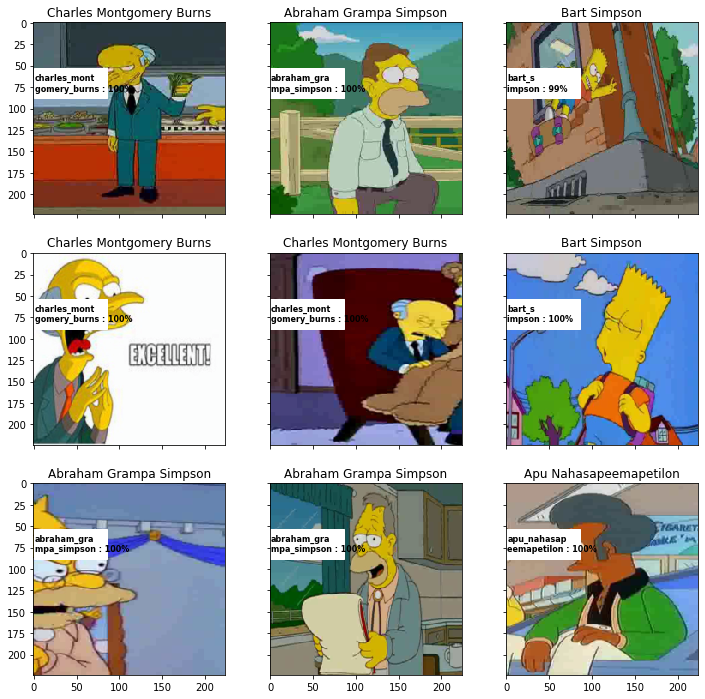

In [0]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), classes[label].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = classes[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [0]:
TEST_DIR = '/content/gdrive/My Drive/simpsons/testset'
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR, train_transforms)

# Визуализация тестовой выборки

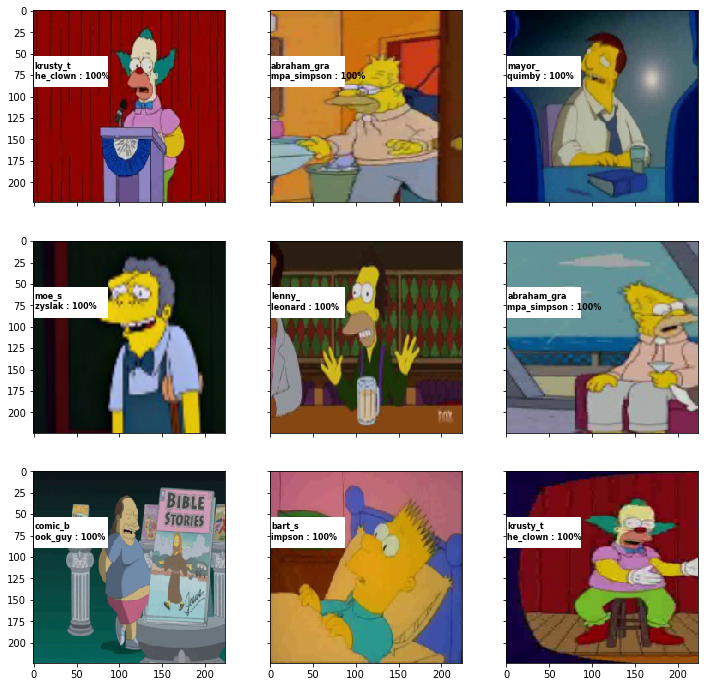

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,990))
    im_val, label = test_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), classes[label].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=None,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(best_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = classes[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

# Сабмит

In [0]:
# Классификация тестовой выборки
test_pred = predict_with_model(best_model, test_dataset, batch_size=40, num_workers=40)
pred = test_pred.argmax(1).reshape(-1)

25it [00:41,  1.66s/it]                            


In [0]:
tst_dir = Path(TEST_DIR)
test_files = sorted(list(tst_dir.rglob('*.jpg')))

In [0]:
lbl_test = list(map(lambda x: str(x).replace('/content/gdrive/My Drive/simpsons/testset/testset/', ''), test_files))
lbl_pred = list(map(lambda x: classes[x], pred))

In [0]:
submission_df = pd.DataFrame.from_dict({'id': lbl_test, 'Expected': lbl_pred})

In [0]:
submission_df.head()

,id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
submission_df.to_csv('submission.csv', index=False)